In [1]:
# disply .tif w/ rasterio example:
# https://github.com/USF-IMARS/l2-processing/blob/main/Example_LP_DAAC_notebooks/Topic_1__AWS_Data_Access.ipynb

'sensor_band_parameters' vars: 
	 wavelength, vcal_gain, vcal_offset, F0, aw, bbw, k_oz, k_no2, Tau_r
'scan_line_attributes' vars: 
	 year, day, msec, detnum, mside, slon, clon, elon, slat, clat, elat, csol_z
'geophysical_data' vars: 
	 aot_869, angstrom, Rrs_412, Rrs_443, Rrs_469, Rrs_488, Rrs_531, Rrs_547, Rrs_555, Rrs_645, Rrs_667, Rrs_678, chlor_a, chl_ocx, Kd_490, pic, poc, ipar, nflh, par, l2_flags
'navigation_data' vars: 
	 longitude, latitude, cntl_pt_cols, cntl_pt_rows, tilt
'processing_control' vars: 
	 


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.


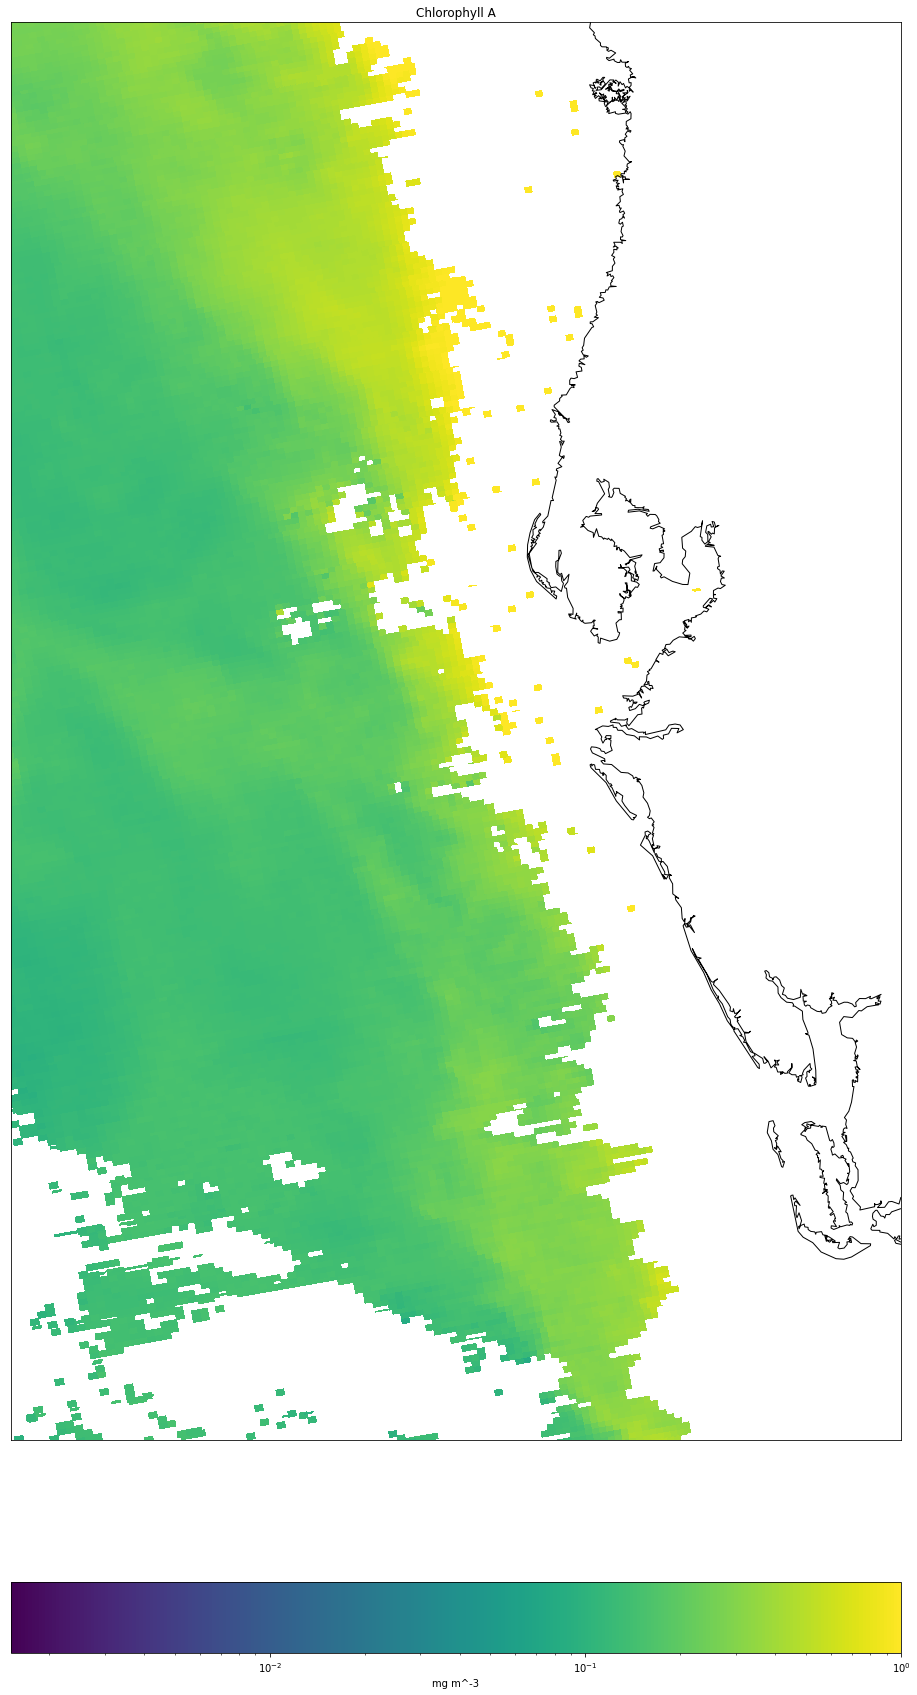

In [13]:
# netcdf viewing

from netCDF4 import Dataset
import numpy as np

my_example_nc_file = './MODA_OC_py_data/A2007143182500.L2_LAC_OC.x.nc'
with Dataset(my_example_nc_file, mode='r') as filehandle:
    # display(filehandle)
    # display(filehandle.variables)
    # display("groups:", filehandle.groups.keys(), "="*100)  # list groups
    for group_key in filehandle.groups.keys():
        # display(dir(filehandle.groups))
        # VAR_GROUP = 'sensor_band_parameters'
        # NAV_GROUP = 'navigation_data'
        # list the vars in the group
        print(f"'{group_key}' vars: \n\t {', '.join(filehandle.groups[group_key].variables.keys())}")
        # display(filehandle.groups[SELECTED_GROUP].variables['longitude'])
    print("="*100)
    
    lons = filehandle.groups['navigation_data'].variables['longitude'][:]
    lats = filehandle.groups['navigation_data'].variables['latitude'][:]
    chlor = filehandle.groups['geophysical_data'].variables['chlor_a'][:]
    
    # TODO: plot histogram & trim boundaries
    #       eg: https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
    # np.histogram(chlor)
    # plt.show()
    # display(chlor)
    
    chlor_units = filehandle.groups['geophysical_data'].variables['chlor_a'].units
    
    import matplotlib.pyplot as plt
    import matplotlib
    from mpl_toolkits.basemap import Basemap
    # Get some parameters for the Stereographic Projection
    lon_0 = filehandle.start_center_longitude
    lat_0 = filehandle.start_center_latitude

    # NOTE: see more options for params here:
    #       https://matplotlib.org/basemap/api/basemap_api.html
    m = Basemap(
        width=5000000,
        height=3500000,
        resolution='h',
        projection='stere',
        # lat_ts=40,
        lat_0=lat_0,
        lon_0=lon_0,
        llcrnrlat=26,
        urcrnrlat=29,
        llcrnrlon=-84,
        urcrnrlon=-82,
    )
    
    lon, lat = lons, lats
    xi, yi = m(lon, lat)
    
    # === clip big/small values
    # TODO: why does the min change the background to purple? are NaNs < 0.05?
    MAX_CHLOR = 1
    MIN_CHLOR = 0.05
    chlor[chlor > MAX_CHLOR] = MAX_CHLOR
    # chlor[(chlor != np.NAN) & (chlor < MIN_CHLOR)] = MIN_CHLOR
    
    # Plot Data
    cs = m.pcolor(
        xi, yi, 
        np.squeeze(chlor),
        # TODO: scale parameter?
        norm=matplotlib.colors.LogNorm()  # plot in log-scale
    )

    # Add Grid Lines
    m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

    # Add Coastlines, States, and Country Boundaries
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()

    # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")
    cbar.set_label(chlor_units)

    # Add Title
    plt.title('Chlorophyll A')
    
    fig = plt.gcf()
    fig.set_size_inches(30,30)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()